## Imports and Function Definitions

In [31]:
import yaml, glob
import pandas as pd
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
import tqdm
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from callbacks import get_callbacks 
import logging
from sklearn.utils import class_weight

In [32]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    # classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    # plt.xlim(-0.5, len(np.unique(y))-0.5)
    # plt.ylim(len(np.unique(y))-0.5, -0.5)
    return ax

def one_hot(x):
    a = np.zeros(len(output_cols))
    a[x] = 1
    return a

def build_model(input_size, hidden_size, output_size):
    model = tf.keras.models.Sequential(
        [tf.keras.layers.Dense(input_size, activation='relu'),
        tf.keras.layers.Dense(hidden_size, activation='relu'),
        tf.keras.layers.Dense(output_size, activation='softmax')]
    )
    return model

# mPING MLP

- trials with/without one hot encoding
- uses class weighting based on the automatic scheme in sklearn

### Get features and outputs from config.yml

In [5]:
config = 'config.yml'
with open(config) as f:
    conf = yaml.load(f, Loader=yaml.FullLoader)
    
# print(conf)
input_cols = conf['tempvars'] + conf['tempdewvars'] + conf['ugrdvars'] + conf['vgrdvars']
output_cols = conf['outputvars']

In [6]:
# sort files by their date
arr = sorted(glob.glob(conf['mping_path']+'*'))

### Load all mPING data

In [7]:
df = pd.read_parquet(conf['work_path']+'mping_data.parquet')

In [5]:
df = pd.concat([pd.read_parquet(x) for x in tqdm.tqdm(arr)])
df.shape

100%|██████████| 2499/2499 [03:25<00:00, 12.16it/s]


(876511, 407)

In [36]:
df.to_parquet(conf['work_path']+'mping_data.parquet')

### Split the data

In [8]:
df['day'] = df['datetime'].apply(lambda x: str(x).split(' ')[0])

In [9]:
splitter = GroupShuffleSplit(n_splits=1, train_size=0.9)

In [10]:
train_idx, test_idx = list(splitter.split(df, groups=df['day']))[0]
train_data, test_data = df.iloc[train_idx], df.iloc[test_idx]

In [11]:
splitter = GroupShuffleSplit(n_splits=1, train_size=0.885)
train_idx, valid_idx = list(splitter.split(train_data, groups=train_data['day']))[0]
train_data, valid_data = train_data.iloc[train_idx], train_data.iloc[valid_idx]

In [12]:
train_data.shape

(692424, 408)

In [13]:
test_data.shape

(92117, 408)

In [14]:
valid_data.shape

(91970, 408)

### Preprocess the data

In [15]:
scaler_x = StandardScaler()

In [16]:
x_train = scaler_x.fit_transform(train_data[input_cols])

In [17]:
x_valid = scaler_x.transform(valid_data[input_cols])

In [18]:
x_test = scaler_x.transform(test_data[input_cols])

#### One hot encoding

In [27]:
train_data['label'] = train_data[output_cols].idxmax(axis=1).apply(lambda x: one_hot(output_cols.index(x)))
y_train = train_data['label'].to_numpy()
y_train = np.vstack(y_train)
y_train.shape

(692218, 4)

In [28]:
valid_data['label'] = valid_data[output_cols].idxmax(axis=1).apply(lambda x: one_hot(output_cols.index(x)))
y_valid = valid_data['label'].to_numpy()
y_valid = np.vstack(y_valid)
y_valid.shape

(91223, 4)

In [29]:
test_data['label'] = test_data[output_cols].idxmax(axis=1).apply(lambda x: one_hot(output_cols.index(x)))
y_test = test_data['label'].to_numpy()
y_test = np.vstack(y_test)
y_test.shape

/glade/scratch/jwillson/ipykernel_86583/1794376418.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['label'] = test_data[output_cols].idxmax(axis=1).apply(lambda x: one_hot(output_cols.index(x)))


(93070, 4)

#### One hot encoding not used

In [19]:
y_train = train_data[output_cols].to_numpy()
y_train.shape

(692424, 4)

In [20]:
y_valid = valid_data[output_cols].to_numpy()
y_valid.shape

(91970, 4)

In [21]:
y_test = test_data[output_cols].to_numpy()
y_test.shape

(92117, 4)

#### Add class weights

In [22]:
classes = [np.argmax(y_train[i]) for i in range(len(y_train))]

In [23]:
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(classes), y=classes)
class_weights

array([0.63572496, 0.54217954, 2.55964157, 5.21089705])

In [24]:
class_weights_dict = {i:class_weights[i] for i in range(4)}
class_weights_dict

{0: 0.6357249620818445,
 1: 0.5421795425929754,
 2: 2.559641573881027,
 3: 5.210897049969898}

### Build Model

In [39]:
model = build_model(len(input_cols), 100, len(output_cols))
model.build((5000, len(input_cols)))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (5000, 268)               72092     
                                                                 
 dense_13 (Dense)            (5000, 100)               26900     
                                                                 
 dense_14 (Dense)            (5000, 4)                 404       
                                                                 
Total params: 99,396
Trainable params: 99,396
Non-trainable params: 0
_________________________________________________________________


### Load Saved Model

In [32]:
model.load_weights(conf['work_path']+'mping_mlp2.h5')

### Compile and Train Model

In [40]:
learning_rate = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate)
loss = tf.keras.losses.CategoricalCrossentropy()
model.compile(loss=loss, optimizer=optimizer, metrics='acc', run_eagerly=True) 
#metrics could be list

In [41]:
callbacks = get_callbacks(conf)
training = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), class_weight=class_weights_dict, callbacks=callbacks,
                     batch_size=5000, shuffle=True, epochs=1000) 
#set as variable

Epoch 1/1000
139/139 [==============================] - 3s 20ms/step - loss: 0.7736 - acc: 0.7619 - val_loss: 0.5702 - val_acc: 0.7916 - lr: 0.0010
Epoch 2/1000
139/139 [==============================] - 3s 18ms/step - loss: 0.6831 - acc: 0.7993 - val_loss: 0.5642 - val_acc: 0.7892 - lr: 0.0010
Epoch 3/1000
139/139 [==============================] - 3s 18ms/step - loss: 0.6619 - acc: 0.8052 - val_loss: 0.5205 - val_acc: 0.8118 - lr: 0.0010
Epoch 4/1000
139/139 [==============================] - 3s 18ms/step - loss: 0.6472 - acc: 0.8101 - val_loss: 0.5615 - val_acc: 0.7952 - lr: 0.0010
Epoch 5/1000
139/139 [==============================] - 3s 18ms/step - loss: 0.6374 - acc: 0.8134 - val_loss: 0.5463 - val_acc: 0.7990 - lr: 0.0010
Epoch 6/1000
139/139 [==============================] - 3s 18ms/step - loss: 0.6180 - acc: 0.8196 - val_loss: 0.5363 - val_acc: 0.8025 - lr: 2.0000e-04
Epoch 7/1000
139/139 [==============================] - 2s 18ms/step - loss: 0.6139 - acc: 0.8205 - val_loss

### Test Model

In [33]:
predictions = model.predict(x_test)
predictions

array([[0.32, 0.06, 0.13, 0.49],
       [0.74, 0.  , 0.04, 0.22],
       [0.62, 0.01, 0.07, 0.3 ],
       ...,
       [0.  , 0.69, 0.29, 0.02],
       [0.  , 0.59, 0.34, 0.06],
       [0.  , 0.77, 0.2 , 0.03]], dtype=float32)

In [34]:
preds = np.argmax(predictions, 1)
labels = np.argmax(y_test,1)
(preds == labels).mean()

0.8236381218437735

Confusion matrix, without normalization
[[29790  1217  1533  1643]
 [  446 38035  4503  1893]
 [  267  1798  5625  1544]
 [  122   598   850  3206]]
Normalized confusion matrix
[[0.87 0.04 0.04 0.05]
 [0.01 0.85 0.1  0.04]
 [0.03 0.19 0.61 0.17]
 [0.03 0.13 0.18 0.67]]


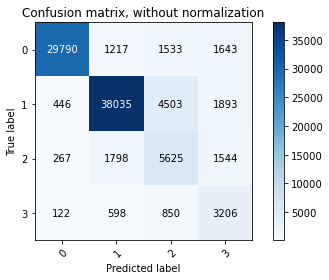

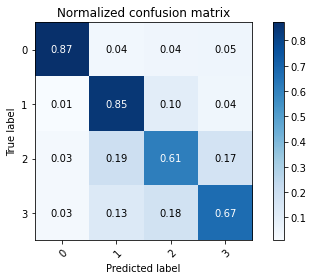

In [35]:
np.set_printoptions(precision=2)
class_names = [str(x) for x in sorted(set(labels))]

# Plot non-normalized confusion matrix
plot_confusion_matrix(labels, preds, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(labels, preds, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()